In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score

In [2]:
df_train = pd.read_csv("../input/titanic/train.csv")
df_test = pd.read_csv("../input/titanic/test.csv")

display(df_train.head())
display(df_test.head())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### Checking Null Values

In [3]:
pd.DataFrame(data = [df_train.isna().sum()/df_train.shape[0]*100, df_test.isna().sum()/df_test.shape[0]*100], index=["Train Null (%)", "Test Null (%)"]).T.style.background_gradient(cmap='summer_r')

,Train Null (%),Test Null (%)
PassengerId,0.000000,0.000000
Survived,0.000000,nan
Pclass,0.000000,0.000000
Name,0.000000,0.000000
Sex,0.000000,0.000000
Age,19.865320,20.574163
SibSp,0.000000,0.000000
Parch,0.000000,0.000000
Ticket,0.000000,0.000000
Fare,0.000000,0.239234


We can see that Age and Cabin variable has quite a lot of null values in both train and test data. Embarked variable in train data has 2 null values, and Fare variable in test data has 1 null value. We will need to analyze this data first to decide whether to drop this column or do some imputation.

In [4]:
print(f"Train data has {df_train.duplicated().sum()} duplicated data")
print(f"Test data has {df_test.duplicated().sum()} duplicated data")

Train data has 0 duplicated data
Test data has 0 duplicated data


No duplicated data in both train and test data. Looks good.

### Checking Dataset Information

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Looks like we have 12 variables, and each variable has 891 records. The types of variables in this dataset are as follows:

**Numerical:**
- **Discrete:**
    1. SibSp
    2. Parch
    <br><br>
    
- **Continous:**
    1. Age
    2. Fare
    <br>
    
**Categorical:**
- **Nominal:**
    1. Sex
    2. Embarked
    3. Survived (Target Variable)
    <br><br>
    
- **Ordinal:**
    1. Pclass
    
**Others:**
- **Text**
    1. Ticket
    2. Name
    <br><br>
    
- **ID:**
    1. PassengerId

# 2. Exploratory Data Analysis

Let's group our variable types and make two functions to visualize our numerical and categorical data first.

In [6]:
num_var = ["SibSp", "Parch", "Age", "Fare"]
cat_var = ["Sex", "Embarked", "Pclass"]
target = "Survived"

In [7]:
def num_dist(data, var):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    sns.histplot(data=data, x=var, kde=True, ax=ax[0])
    sns.boxplot(data=data, x=var, ax=ax[1])
    ax[0].set_title(f"{var} Distribution Histogram")
    ax[1].set_title(f"{var} Distribution Boxplot")

    plt.show()
    
def cat_dist(data, var):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    df_train[var].value_counts().plot(kind="pie", explode=[0.05 for x in data[var].dropna().unique()], autopct='%1.1f%%', ax=ax[0], shadow=True)
    ax[0].set_title(f"{var} Pie Chart")
    ax[0].set_ylabel('')

    count = sns.countplot(x=var, data=df_train, ax=ax[1])
    for bar in count.patches:
        count.annotate(format(bar.get_height()),
            (bar.get_x() + bar.get_width() / 2,
            bar.get_height()), ha='center', va='center',
            size=11, xytext=(0, 8),
            textcoords='offset points')
    ax[1].set_title(f"{var} Bar Chart")
    plt.show()

## 2.1 Checking Target Distribution

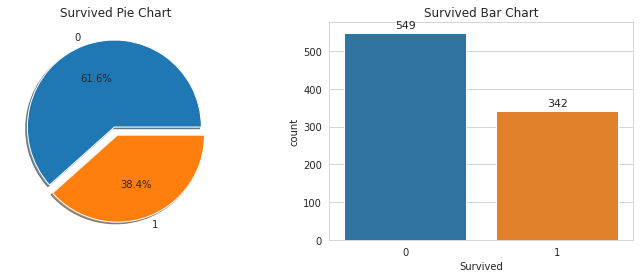

In [8]:
cat_dist(df_train, "Survived")

Unfortunately, 61,6% passengers did not survive the fatal accident. Only 342 passengers survived out of a total of 891 passengers in the training data. So, what caused them to survive the accident. We will try to analyze the features in this dataset that might be able to answer this question.

So, Let's begin.

## 2.2 Checking Predictor Distribution

### 2.2.1 Numerical

In [9]:
df_train[num_var].describe()

,SibSp,Parch,Age,Fare
count,891.000000,891.000000,714.000000,891.000000
mean,0.523008,0.381594,29.699118,32.204208
std,1.102743,0.806057,14.526497,49.693429
min,0.000000,0.000000,0.420000,0.000000
25%,0.000000,0.000000,20.125000,7.910400
50%,0.000000,0.000000,28.000000,14.454200
75%,1.000000,0.000000,38.000000,31.000000
max,8.000000,6.000000,80.000000,512.329200


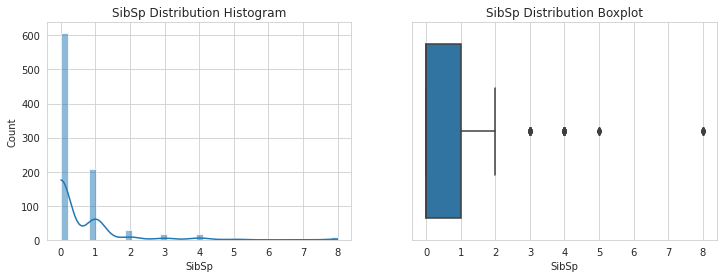

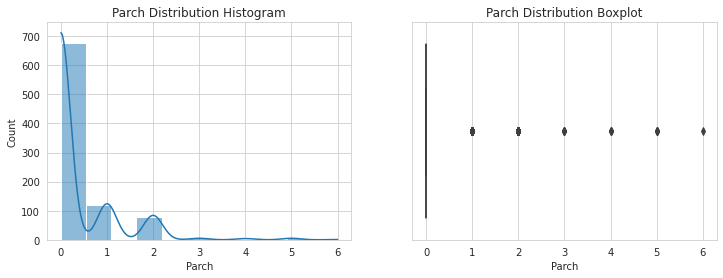

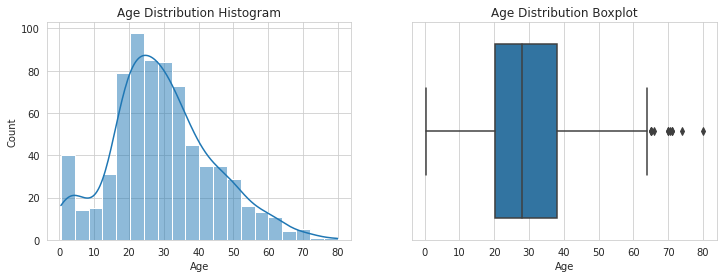

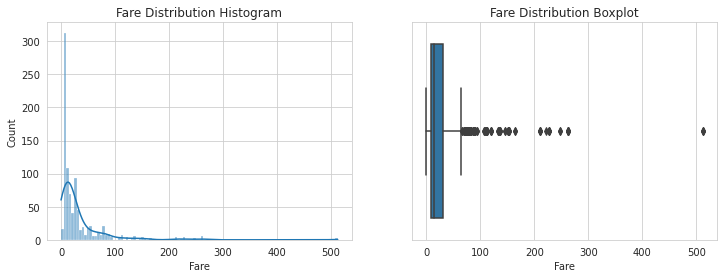

In [10]:
for var in num_var:
    num_dist(df_train, var)

Most passengers at that time traveled alone without their families. The age of the passengers also varies from 0.42 to 80 years, with an average of 29.7 years. Fares for these passengers also vary, but what's interesting here is that there are passengers who don't have to pay for this cruise. 

As we can see, all of the above variables have outliers. Age variable seems to have almost a normal distribution, but there are some outliers that cause the distribution to be skewed to the right. Other variables appear to have a right skewed distribution because of that.

### 2.2.2 Categorical

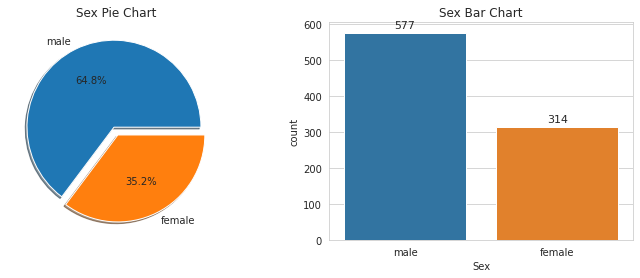

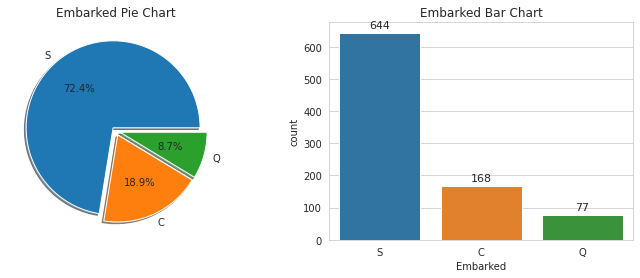

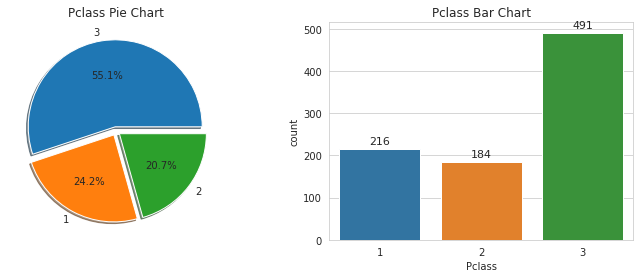

In [11]:
for var in cat_var:
    cat_dist(df_train, var)

64.8% of the passengers in this training set are male, while the remaining 35.2% are female. More than 70% of these passengers embarked from port S (Southampton). Very few passengers embarked from port Q (Queenstown), which is only 8.7%, while the rest embarked from port C (Cherbourg). Most of the passengers have 3rd ticket class, while the number of passengers who have 1st and 2nd ticket class is almost equal.

## 2.3 Survived vs Not Survived

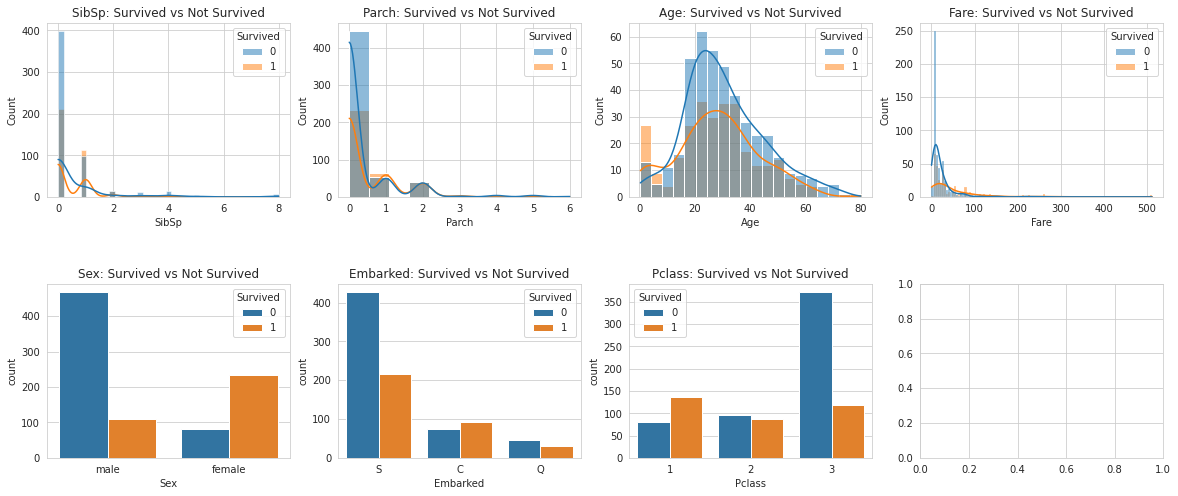

In [12]:
fig, ax = plt.subplots(2, 4, figsize=(20, 8))
ax = ax.flatten()

for i, var in enumerate(num_var+cat_var):
    if i < 4:
        sns.histplot(data=df_train, x=var, hue=target, kde=True, ax=ax[i])
    else:
        sns.countplot(data=df_train, x=var, hue=target, ax=ax[i])
    
    ax[i].set_title(f"{var}: Survived vs Not Survived")
    
plt.subplots_adjust(hspace=0.5)
plt.show()

Apparently, passengers who travel with small numbers of family have a greater survival chance. Also, large number of children (Age <= 10) survived in this tragedy, while passengers with the age above them tend not to survive. We can also see the number of female who survived was much more than male (women and children first code). Passengers embarked from port C seem to be luckier as many of them survived. Pclass also plays quite a role here because most of the passengers from Pclass 1 managed to survive or have more priority to be saved, while passengers with Pclass 3 tend not to survive.

Now, let's get deeper.

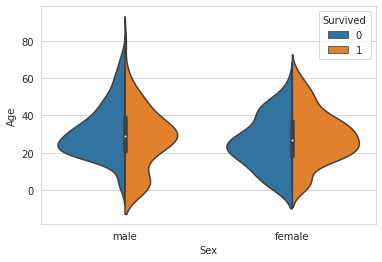

In [13]:
sns.violinplot(data=df_train, x="Sex", y="Age", hue="Survived", split=True)
plt.show()

Children survival rate for both gender seems to be good, even though the survival rate for boys is higher. For old people (Age > 60), the survival rate for old men tends to be lower, in contrast to the survival rate for old women which tends to be higher.

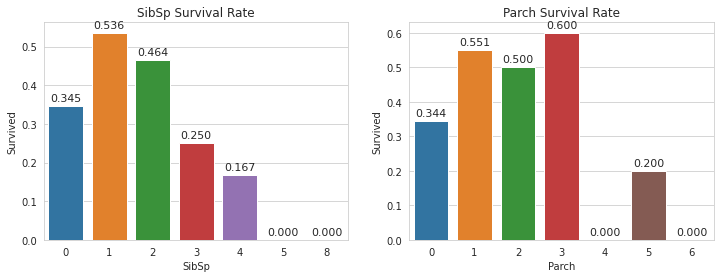

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

for i, var in enumerate(["SibSp", "Parch"]):
    surv = sns.barplot(data=df_train, x=var, y=target, ax=ax[i], ci=None)
    for bar in surv.patches:
        surv.annotate(format("{:.3f}".format(bar.get_height())),
            (bar.get_x() + bar.get_width() / 2,
            bar.get_height()), ha='center', va='center',
            size=11, xytext=(0, 8),
            textcoords='offset points')
        
    ax[i].set_title(f"{var} Survival Rate")

The graph above shows that passengers with small numbers of family tend to survive. Meanwhile, there are only ~34% of the lone passengers (SibSpb and Parch = 0) who survived. Unfortunately, 0% passengers with SibSp > 4 survived, and almost no passengers with Parch > 3 survived.

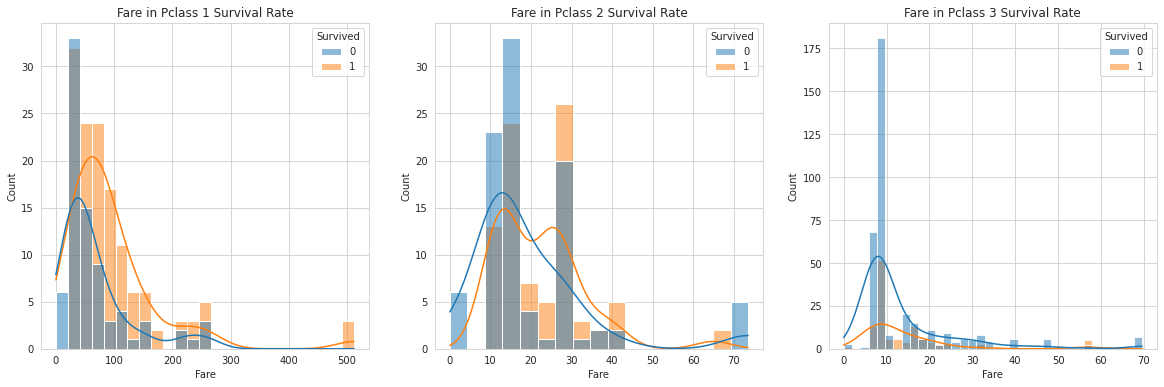

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

for i, pc in enumerate(sorted(df_train["Pclass"].unique())):
    sns.histplot(data=df_train[df_train["Pclass"]==pc], x="Fare", hue=target, kde=True, ax=ax[i])
    ax[i].set_title(f"Fare in Pclass {pc} Survival Rate")

Passengers with higher fares are more likely to survive these accidents, although some of those with the highest fares on the Pclass 2 didn't survive. Even though most of the passengers who didn't survive were those with Pclass 3, but Pclass 1 and 2 also did not guarantee passenger safety, especially for those with less fares.

# 3. Feature Engineering

## 3.1 PassengerId

In [16]:
df_train["PassengerId"]

0        1
1        2
2        3
3        4
4        5
      ... 
886    887
887    888
888    889
889    890
890    891
Name: PassengerId, Length: 891, dtype: int64

This variable only contains the unique identity number of each passenger and cannot be categorized, so we can just remove this variable.

In [17]:
df_train_prep = df_train.drop("PassengerId", axis=1)
df_test_prep = df_test.drop("PassengerId", axis=1)

## 3.2 Name

In [18]:
df_train["Name"]

0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
                             ...                        
886                                Montvila, Rev. Juozas
887                         Graham, Miss. Margaret Edith
888             Johnston, Miss. Catherine Helen "Carrie"
889                                Behr, Mr. Karl Howell
890                                  Dooley, Mr. Patrick
Name: Name, Length: 891, dtype: object

As we can see, in the names of the passengers there is a pattern that we can extract, which is their title (Mr, Mrs, Miss, etc.). Let's extract the string value followed by dot (.).

In [19]:
df_train_prep["Title"] = df_train_prep["Name"].str.extract('([A-Za-z]+)\.')
df_test_prep["Title"] = df_test_prep["Name"].str.extract('([A-Za-z]+)\.')

df_train_prep["Title"].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Countess      1
Capt          1
Ms            1
Sir           1
Lady          1
Mme           1
Don           1
Jonkheer      1
Name: Title, dtype: int64

Some initials are owned by very few people, and some initials have the same meaning as others. We will group them according to the proper group.

In [20]:
def convert_title(title):
    if title in ["Ms", "Mile", "Miss"]:
        return "Miss"
    elif title in ["Mme", "Mrs"]:
        return "Mrs"
    elif title == "Mr":
        return "Mr"
    elif title == "Master":
        return "Master"
    else:
        return "Other"
        
df_train_prep["Title"] = df_train_prep["Title"].map(convert_title)
df_test_prep["Title"] = df_test_prep["Title"].map(convert_title)

df_train_prep["Title"].value_counts()

Mr        517
Miss      183
Mrs       126
Master     40
Other      25
Name: Title, dtype: int64

We've got the initials of each passenger, so now the variable name is no longer needed. We can remove this variable now.

In [21]:
df_train_prep = df_train_prep.drop("Name", axis=1)
df_test_prep = df_test_prep.drop("Name", axis=1)

## 3.3 Ticket

In [22]:
df_train_prep["Ticket"]

0             A/5 21171
1              PC 17599
2      STON/O2. 3101282
3                113803
4                373450
             ...       
886              211536
887              112053
888          W./C. 6607
889              111369
890              370376
Name: Ticket, Length: 891, dtype: object

This variable also only contains the unique ticket value for each passenger, and there is no pattern that we can extract. So, we'll just remove this variable.

In [23]:
df_train_prep = df_train_prep.drop("Ticket", axis=1)
df_test_prep = df_test_prep.drop("Ticket", axis=1)

## 3.4 Cabin

This variable has too many missing values in both train and test data (more than 77%), so this variable is useless. We will also remove this variable.

In [24]:
df_train_prep = df_train_prep.drop("Cabin", axis=1)
df_test_prep = df_test_prep.drop("Cabin", axis=1)

## 3.5 Age

The age variable has a missing value of 19.87% in the training data and 20.57% in the test data. That number is not really much, so we will try to do data imputation on this variable. So, how are we going to do that?

Usually, we can just fill missing values using mean or median values. But the problem is, this dataset contains many passengers with many different ages. We just cant assign a 4 year kid or 60 years old man with the mean age that is 29 years. First, let's check the correlation between age variable with other variables.

In [25]:
df_train_prep.corr()["Age"].sort_values(ascending=False)

Age         1.000000
Fare        0.096067
Survived   -0.077221
Parch      -0.189119
SibSp      -0.308247
Pclass     -0.369226
Name: Age, dtype: float64

Doesn't look so good. Now let's try to check with another variable which is title variable.

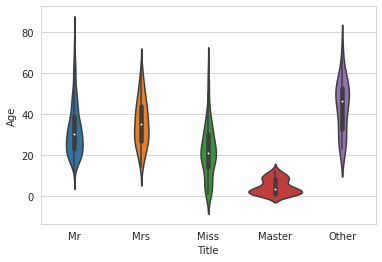

In [26]:
sns.violinplot(data=df_train_prep, x="Title", y="Age")
plt.show()

That looks pretty good. We can use Title variable to classify the age of the passengers. Let's check passenger's average age based on their title.

In [27]:
df_train_prep.groupby('Title')['Age'].mean()

Title
Master     4.574167
Miss      21.816327
Mr        32.368090
Mrs       35.788991
Other     43.750000
Name: Age, dtype: float64

Fill in the missing age value using the average passenger age for each title.

In [28]:
df_train_prep.loc[(df_train_prep.Age.isnull()) & (df_train_prep["Title"]=='Master'), 'Age'] = 5
df_train_prep.loc[(df_train_prep.Age.isnull()) & (df_train_prep["Title"]=='Miss'), 'Age'] = 22
df_train_prep.loc[(df_train_prep.Age.isnull()) & (df_train_prep["Title"]=='Mr'), 'Age'] = 32
df_train_prep.loc[(df_train_prep.Age.isnull()) & (df_train_prep["Title"]=='Mrs'), 'Age'] = 36
df_train_prep.loc[(df_train_prep.Age.isnull()) & (df_train_prep["Title"]=='Other'), 'Age'] = 44

In [29]:
df_test_prep.loc[(df_test_prep.Age.isnull())&(df_test_prep["Title"]=='Master'), 'Age'] = 5
df_test_prep.loc[(df_test_prep.Age.isnull())&(df_test_prep["Title"]=='Miss'), 'Age'] = 22
df_test_prep.loc[(df_test_prep.Age.isnull())&(df_test_prep["Title"]=='Mr'), 'Age'] = 32
df_test_prep.loc[(df_test_prep.Age.isnull())&(df_test_prep["Title"]=='Mrs'), 'Age'] = 36
df_test_prep.loc[(df_test_prep.Age.isnull())&(df_test_prep["Title"]=='Other'), 'Age'] = 44

## 3.6 Fare

We know that Fare variable in test data has missing value, so we will try to impute that variable value based on train data. Let's check the correlation Fare variable with other variables.

In [30]:
df_train_prep.corr()["Fare"].sort_values(ascending=False)

Fare        1.000000
Survived    0.257307
Parch       0.216225
SibSp       0.159651
Age         0.092122
Pclass     -0.549500
Name: Fare, dtype: float64

As we can see, Pclass variable has a relatively strong negative correlation with Fare variable. So, we will use the mean value of Fare based on the Pclass variable to fill in the missing values. 

In [31]:
df_test_prep[df_test_prep["Fare"].isna()]

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
152,3,male,60.5,0,0,NaN,S,Mr


Pclass = 3

In [32]:
df_test_prep.Fare.fillna(df_train.groupby("Pclass").mean()["Fare"][3], inplace=True)

## 3.7 Pclass

From the previous analysis, we know that the Pclass variable has a fairly high correlation with the Fare variable. But surprisingly, the correlation is negative, while that two variables should have a positive correlation. Therefore, we will change the value of the Pclass variable to match what we expected.

In [33]:
df_train_prep["Pclass"].replace([1,2,3], [3,2,1], inplace=True)
df_test_prep["Pclass"].replace([1,2,3], [3,2,1], inplace=True)

## 3.8 Categorical Variable Encoding

In [34]:
df_train_prep = pd.get_dummies(df_train_prep, prefix=["Sex", "Embarked", "Title"])
df_test_prep = pd.get_dummies(df_test_prep, prefix=["Sex", "Embarked", "Title"])

# 4. Model Building

In [35]:
from sklearn.model_selection import train_test_split
X = df_train_prep.drop(['Survived'],axis=1)
y = (df_train.copy())['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=4686)


# Split the (training) data to train and test

#X_train = df_train_prep.drop("Survived", axis=1)
#y_train = df_train_prep.Survived

X_fintest = df_test_prep.copy()


In [36]:
X_fintest.describe()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Other
count,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000
mean,1.734450,30.106459,0.447368,0.392344,35.574673,0.363636,0.636364,0.244019,0.110048,0.645933,0.050239,0.188995,0.574163,0.172249,0.014354
std,0.841838,13.014864,0.896760,0.981429,55.850822,0.481622,0.481622,0.430019,0.313324,0.478803,0.218700,0.391974,0.495062,0.378049,0.119088
min,1.000000,0.170000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,22.000000,0.000000,0.000000,7.895800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,30.000000,0.000000,0.000000,14.454200,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,3.000000,36.000000,1.000000,0.000000,31.471875,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,3.000000,76.000000,8.000000,9.000000,512.329200,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 4.1 Feature Scaling

In [37]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_fintest_scaled = scaler.transform(X_fintest)

In [38]:
classifiers = {
    "KNN": KNeighborsClassifier(), 
    "LR": LogisticRegression(max_iter=1000), 
    "DT": DecisionTreeClassifier(),
    "RF": RandomForestClassifier(),
    "SVM": SVC(),
    "MLP": MLPClassifier(max_iter=1000),
    "XGB": XGBClassifier(),
    "LGBM": LGBMClassifier(),
    "ADA" : AdaBoostClassifier(n_estimators=100),
    "GBC" : GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
}

results = dict()
for name, clf in classifiers.items():
    model = clf
    cv_results = cross_validate(
        model, X_train_scaled, y_train, cv=5,
        scoring=('accuracy')
    )

    results[name] = cv_results['test_score'].mean()
    
results

/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


{'KNN': 0.8142408259454607,
 'LR': 0.8233307148468185,
 'DT': 0.767871170463472,
 'RF': 0.8023454157782515,
 'SVM': 0.8203231960498261,
 'MLP': 0.8067781393782966,
 'XGB': 0.8337223656155313,
 'LGBM': 0.8277409942767366,
 'ADA': 0.8008528784648188,
 'GBC': 0.8067893614633599}

In [39]:
import warnings
warnings.filterwarnings("ignore")

params = {
    #"boosting_type": ["gbdt", "dart", "goss"],
    "max_depth": [1, 3, 5],
    "learning_rate": [0.1, 0.05, 0.01],
    "n_estimators": [10, 50, 100, 300]
}
params2 = {
    "max_iter": [100, 300, 500, 1000]
}
lgbm = LGBMClassifier(random_state=0)
lgbm_clf = GridSearchCV(lgbm, params, cv=10)
lgbm_clf.fit(X_train_scaled, y_train)
print("LGBM Best hyperparameter:", lgbm_clf.best_params_)

svm = GradientBoostingClassifier(random_state=0)
svm_clf = GridSearchCV(svm, params, cv=10)
svm_clf.fit(X_train_scaled, y_train)
print("SVM Best hyperparameter:", svm_clf.best_params_)

xgb = XGBClassifier(random_state=0)
xgb_clf = GridSearchCV(xgb, params, cv=10)
xgb_clf.fit(X_train_scaled, y_train)
print("XGB Best hyperparameter:", xgb_clf.best_params_)

lrc = LogisticRegression(random_state=0)
lrc_clf = GridSearchCV(lrc, params2, cv=10)
lrc_clf.fit(X_train_scaled, y_train)
print("LRC Best hyperparameter:", lrc_clf.best_params_)


LGBM Best hyperparameter: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
SVM Best hyperparameter: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300}
XGB Best hyperparameter: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
LRC Best hyperparameter: {'max_iter': 100}


In [40]:
from sklearn.ensemble import VotingClassifier

# Use the accuracies for test data as the weights
vote_clf = VotingClassifier(
    estimators= [('lgbm', lgbm_clf), ('svm', svm_clf), ('xgb', xgb_clf), ('lrc', lrc_clf)],
    voting='hard'
)

vote_clf.fit(X_train_scaled, y_train)
pred_vote = vote_clf.predict(X_train_scaled)
print(classification_report(y_train, pred_vote))
#np.mean(cross_val_score(vote_clf, X_train_scaled, y_train, cv=10), 0)
#pred_vote_test = vote_clf.predict(X_test)
#print(classification_report(y_test, pred_vote_test))

#vote_clf2 = VotingClassifier(
#    estimators= [('lr', lr_clf), ('svc', svc_chosen), ('rf', random_forest)],
#    voting='hard'
#)

#vote_clf2.fit(X_train, y_train)
#pred_vote2 = vote_clf2.predict(X_train)
#print(classification_report(y_train, pred_vote2))

              precision    recall  f1-score   support

           0       0.92      0.97      0.95       407
           1       0.95      0.87      0.91       261

    accuracy                           0.93       668
   macro avg       0.94      0.92      0.93       668
weighted avg       0.93      0.93      0.93       668



In [41]:
np.mean(cross_val_score(vote_clf, X_train_scaled, y_train, cv=8), 0)
#pred_vote_test = vote_clf.predict(X_test)
#print(classification_report(y_test, pred_vote_test))

0.8442340791738382

In [42]:
y_test_pred = vote_clf.predict(X_test_scaled)
print(classification_report(y_test_pred, y_test))


              precision    recall  f1-score   support

           0       0.88      0.86      0.87       145
           1       0.75      0.78      0.77        78

    accuracy                           0.83       223
   macro avg       0.82      0.82      0.82       223
weighted avg       0.84      0.83      0.83       223



In [43]:
y_pred = vote_clf.predict(X_fintest_scaled)

submission = pd.DataFrame({
    "PassengerId": df_test["PassengerId"],
    "Survived": y_pred })
submission.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")



Your submission was successfully saved!
